This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

We are interesting in doing 1month vs 30month, male kidney

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib.pyplot import rc_context

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.23.5 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [2]:
data_path = f"{os.getcwd()}/../../data/bulk_data/liver_sex/"

# file downloaded from SeuratData then converted to h5ad 



in_file = f"{data_path}/GSE132040_190214.csv"
meta_file = f"{data_path}/GSE132040_MACA_Bulk_metadata.csv"
results_file = f"{data_path}/liver_bulk_processed.h5ad"
de_results_file = f"{data_path}/de_real_bulk_results.pkl"

with open(in_file) as your_data:
    adata = ad.read_csv(your_data, delimiter=',')
    adata = adata.transpose()
    
# add in all the metadata
obs_df = pd.read_csv(meta_file)
obs_df = obs_df.set_index(obs_df["Sample name"] + ".gencode.vM19")

# remake anndata
adata = ad.AnnData(adata.X, obs=obs_df, var=adata.var)
adata


AnnData object with n_obs × n_vars = 947 × 54357
    obs: 'Sample name', 'title', 'source name', 'organism', 'characteristics: age', 'characteristics: developmental stage', 'characteristics: sex', 'molecule', 'description', 'processed data file ', 'raw file', 'BioSample', 'Instrument Model'

In [3]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

# remove non-gene IDs
gene_idx = np.where(np.logical_not(adata.var_names.str.startswith('__')))[0]
adata = adata[:, gene_idx]



In [4]:
adata.var_names[np.where(adata.var_names.str.startswith('__'))]

Index([], dtype='object')

In [5]:
# format the tissue 
adata.obs["tissue"] = [x.split("_")[0] for x in adata.obs["source name"]]

# subset to kidney
#adata = adata[np.where(adata.obs["tissue"] == "Kidney")]
adata = adata[np.where(adata.obs["tissue"] == "Liver")]
adata = adata[np.where(adata.obs["characteristics: age"] != "1")]

adata.obs

<ipython-input-5-886cf970a9e4>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["tissue"] = [x.split("_")[0] for x in adata.obs["source name"]]


,Sample name,title,source name,organism,characteristics: age,characteristics: developmental stage,characteristics: sex,molecule,description,processed data file,raw file,BioSample,Instrument Model,tissue
Sample name,,,,,,,,,,,,,,
A12_384Bulk_Plate2_S12.gencode.vM19,A12_384Bulk_Plate2_S12,Tabula Muris Senis (bulk RNA seq),Liver_56,Mus musculus C57/BL6,6,months postnatal,m,total RNA,NaN,190214_A00111_0269_AHH3J3DSXX__190214_A00111_0...,SRR9126831,SAMN11854575,Illumina NovaSeq 6000,Liver
A21_384Bulk_Plate2_S21.gencode.vM19,A21_384Bulk_Plate2_S21,Tabula Muris Senis (bulk RNA seq),Liver_46,Mus musculus C57/BL6,6,months postnatal,m,total RNA,NaN,190214_A00111_0269_AHH3J3DSXX__190214_A00111_0...,SRR9127503,SAMN11854599,Illumina NovaSeq 6000,Liver
A6_384Bulk_Plate1_S6.gencode.vM19,A6_384Bulk_Plate1_S6,Tabula Muris Senis (bulk RNA seq),Liver_8,Mus musculus C57/BL6,3,months postnatal,f,total RNA,NaN,190214_A00111_0269_AHH3J3DSXX__190214_A00111_0...,SRR9127256,SAMN11854613,Illumina NovaSeq 6000,Liver
A7_384Bulk_Plate3_S7.gencode.vM19,A7_384Bulk_Plate3_S7,Tabula Muris Senis (bulk RNA seq),Liver_14,Mus musculus C57/BL6,3,months postnatal,m,total RNA,NaN,190214_A00111_0269_AHH3J3DSXX__190214_A00111_0...,SRR9127050,SAMN11854618,Illumina NovaSeq 6000,Liver
A8_384Bulk_Plate2_S8.gencode.vM19,A8_384Bulk_Plate2_S8,Tabula Muris Senis (bulk RNA seq),Liver_9,Mus musculus C57/BL6,15,months postnatal,f,total RNA,NaN,190214_A00111_0269_AHH3J3DSXX__190214_A00111_0...,SRR9127056,SAMN11854620,Illumina NovaSeq 6000,Liver
B6_384Bulk_Plate3_S30.gencode.vM19,B6_384Bulk_Plate3_S30,Tabula Muris Senis (bulk RNA seq),Liver_39,Mus musculus C57/BL6,12,months postnatal,m,total RNA,NaN,190214_A00111_0269_AHH3J3DSXX__190214_A00111_0...,SRR9127212,SAMN11854674,Illumina NovaSeq 6000,Liver
B8_384Bulk_Plate2_S32.gencode.vM19,B8_384Bulk_Plate2_S32,Tabula Muris Senis (bulk RNA seq),Liver_32,Mus musculus C57/BL6,21,months postnatal,m,total RNA,NaN,190214_A00111_0269_AHH3J3DSXX__190214_A00111_0...,SRR9126712,SAMN11854679,Illumina NovaSeq 6000,Liver
C11_384Bulk_Plate2_S59.gencode.vM19,C11_384Bulk_Plate2_S59,Tabula Muris Senis (bulk RNA seq),Liver_25,Mus musculus C57/BL6,18,months postnatal,m,total RNA,NaN,190214_A00111_0269_AHH3J3DSXX__190214_A00111_0...,SRR9126770,SAMN11854691,Illumina NovaSeq 6000,Liver
C14_384Bulk_Plate1_S62.gencode.vM19,C14_384Bulk_Plate1_S62,Tabula Muris Senis (bulk RNA seq),Liver_26,Mus musculus C57/BL6,18,months postnatal,m,total RNA,NaN,190214_A00111_0269_AHH3J3DSXX__190214_A00111_0...,SRR9126918,SAMN11854699,Illumina NovaSeq 6000,Liver


In [6]:
# how many of each mouse
tab = adata.obs.groupby(['characteristics: age', 'characteristics: sex']).size()

tab.unstack()

characteristics: sex,f,m
characteristics: age,,
12,2.0,4.0
15,2.0,4.0
18,2.0,4.0
21,2.0,4.0
24,NaN,3.0
27,NaN,4.0
3,2.0,4.0
6,2.0,4.0
9,2.0,4.0


In [7]:

sex_adata = adata[np.where(adata.obs["characteristics: sex"] == "f")[0]]

# how many of each mouse
tab = sex_adata.obs.groupby(['characteristics: age', 'source name']).size()
tab.unstack()

source name,Liver_1,Liver_2,Liver_21,Liver_24,Liver_27,Liver_29,Liver_31,Liver_33,Liver_4,Liver_47,Liver_48,Liver_6,Liver_8,Liver_9
characteristics: age,,,,,,,,,,,,,,
12,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
6,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:

sex_adata = adata[np.where(adata.obs["characteristics: sex"] == "m")[0]]

# how many of each mouse
tab = sex_adata.obs.groupby(['source name', 'characteristics: age']).size()
tab.unstack()

characteristics: age,12,15,18,21,24,27,3,6,9
source name,,,,,,,,,
Liver_10,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Liver_11,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Liver_12,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Liver_13,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Liver_14,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Liver_16,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Liver_17,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Liver_18,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Liver_19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## format the obs for BuDDI

In [9]:
# now make pairings of samples
# merge them
#samp_dict = {'samp1': ["Kidney_44", "Kidney_17", "Kidney_28", "Kidney_9", "Kidney_36", "Kidney_46"],
#             'samp2': ["Kidney_23", "Kidney_49", "Kidney_47", "Kidney_11", "Kidney_32"],
#             'samp3': ["Kidney_37", "Kidney_15", "Kidney_41", "Kidney_3"],
#             'samp4': ["Kidney_50", "Kidney_34", "Kidney_20", "Kidney_14"]}

#samp_dict = {'samp1': ["Lung_7", "Lung_36", "Lung_32", "Lung_18", "Lung_19", "Lung_21"],
#             'samp2': ["Lung_39", "Lung_27", "Lung_45", "Lung_23", "Lung_29"],
#             'samp3': ["Lung_40", "Lung_50", "Lung_4", "Lung_9"],
#             'samp4': ["Lung_24", "Lung_42", "Lung_26", "Lung_54"]}

# Initialize empty column in cell metadata
adata.obs['sample_id'] = adata.obs['source name']

# Generate new assignments
#for i in samp_dict.keys():
#    ind = pd.Series(adata.obs["source name"]).isin(samp_dict[i])
#    adata.obs.loc[ind,'sample_id'] = i



def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "m":
        out_str = "CTRL"
           
    return(out_str)

adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs["characteristics: sex"].tolist()]
adata.var['gene_ids'] = adata.var.index.tolist()


<ipython-input-9-08a197ff5b42>:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sample_id'] = adata.obs['source name']


In [10]:
# how many of each mouse
tab = adata.obs.groupby(['stim', 'sample_id']).size()
tab.unstack()

sample_id,Liver_1,Liver_10,Liver_11,Liver_12,Liver_13,Liver_14,Liver_16,Liver_17,Liver_18,Liver_19,...,Liver_49,Liver_5,Liver_50,Liver_52,Liver_53,Liver_56,Liver_6,Liver_7,Liver_8,Liver_9
stim,,,,,,,,,,,,,,,,,,,,,
CTRL,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN
STIM,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0


## Preprocessing

normalizing counts per cell
    finished (0:00:00)


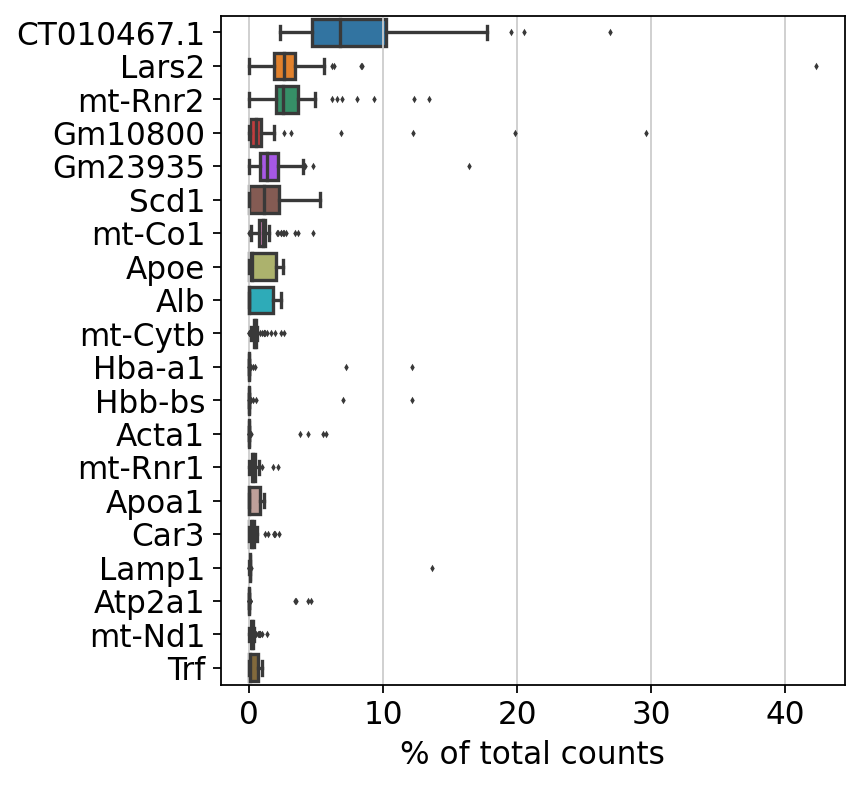

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20, )


# Diff Exp

In [12]:
def get_DE(in_adata):

    meta_DESeq = in_adata.obs
    expr_matr = pd.DataFrame(in_adata.X, 
                             columns=in_adata.var.gene_ids, 
                             index=in_adata.obs.sample_id)

    # reindex so that anndata obj can be created easily
    meta_DESeq.index = expr_matr.index


    # filter out lowly expressed genes
    genes_to_keep = expr_matr.columns[expr_matr.mean(axis=0) > 1]
    expr_matr = expr_matr[genes_to_keep]    
    print(expr_matr.shape)                
    print(meta_DESeq.shape)                

    # run deseq
    dds_bulk = DeseqDataSet(
        counts=expr_matr,
        clinical=meta_DESeq,
        design_factors=["stim"],
        refit_cooks=True
    )

    print("running contrast")

    dds_bulk.deseq2()
    cell_res = DeseqStats(dds_bulk, contrast=["stim", "STIM", "CTRL"])
    cell_res.summary()

    # get the DESeq res matrix
    cell_res_df = cell_res.results_df

    # get the genes of interest
    cell_res_df_sig = cell_res_df.iloc[np.where(cell_res_df["padj"] < 0.01)[0]]
    cell_res_df_sig = cell_res_df_sig.iloc[np.argsort(np.abs(cell_res_df_sig["log2FoldChange"]))]
    top_genes = cell_res_df_sig.index.to_list()

    return (top_genes, cell_res_df) 

In [13]:
top_genes, res_df = get_DE(adata)

(49, 38710)
(49, 16)
running contrast
Fitting size factors...
... done in 0.07 seconds.

Fitting dispersions...
... done in 25.02 seconds.

Fitting dispersion trend curve...
... done in 18.57 seconds.

Fitting MAP dispersions...
... done in 10.89 seconds.

Fitting LFCs...
... done in 10.49 seconds.

Refitting 9910 outliers.

Fitting dispersions...
... done in 6.22 seconds.

Fitting MAP dispersions...
... done in 2.79 seconds.

Fitting LFCs...
... done in 2.88 seconds.

Running Wald tests...
... done in 4.37 seconds.

Log2 fold change & Wald test p-value: stim STIM vs CTRL


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
0610005C13Rik,441.851058,0.046009,0.881267,0.052207,0.958364,0.986985
0610006L08Rik,5.163355,1.187634,0.946018,1.255404,0.209332,NaN
0610009B22Rik,87.232504,0.001948,0.278620,0.006992,0.994421,0.998261
0610009E02Rik,3.744421,0.449620,0.478517,0.939611,0.347417,NaN
0610009L18Rik,16.790412,-0.518876,0.615956,-0.842392,0.399569,0.710293
...,...,...,...,...,...,...
n-R5s67,3.599303,-0.028208,0.567923,-0.049669,0.960387,NaN
n-R5s70,1.658311,0.439240,1.345137,0.326539,0.744017,NaN
n-R5s72,2.440407,1.627112,1.180346,1.378504,0.168048,NaN


In [14]:
top_genes

['Rassf3',
 'Ociad2',
 'AK157302',
 'Muc1',
 'Gstp2',
 'Mcm5',
 'Grm8',
 'Gstp1',
 'Cdca2',
 'Rrm2',
 'Nuf2',
 'Ckap2l',
 'Tpx2',
 'Acsl6',
 'Cenpf',
 'Hmgb2',
 'Fignl1',
 'Cdca8',
 'Jph1',
 '1810053B23Rik',
 'Nexn',
 'Hao2',
 'Top2a',
 'Gm13855',
 'Cyp4a31',
 'Ano5',
 'Sult2a7',
 'Tpm2',
 '9030619P08Rik',
 'Mgam2-ps',
 'Slc22a27',
 'Mki67',
 'Hspb6',
 'Akap6',
 'Tmem38a',
 'Abra',
 'Asb2',
 'Mylpf',
 'Mylk4',
 'Hba-a2',
 'Acot3',
 'Ltf',
 'Ankrd23',
 'Mup21',
 'Trdn',
 'Pgam2',
 'Cyp3a44',
 'Igha',
 'Scn4a',
 'Actn2',
 'Tff3',
 'Cyp2a22',
 'Olfm4',
 'Cyp2d9',
 'Cyp2c40',
 'Slc22a26',
 'Reg3a',
 'Camk2a',
 'Spink1',
 'Mpo',
 'Cyp3a41a',
 'Klhl41',
 'Ngp',
 'Cmya5',
 'Hspb7',
 'Pygm',
 'Xirp2',
 'Klhl31',
 'Cyp4a12a',
 'Sult3a1',
 'Ttn',
 'Eno3',
 'Fmo3',
 'Lct',
 'Mup20',
 'Zg16',
 'Cyp2c69',
 'Cyp2b13',
 'Actc1',
 '3425401B19Rik',
 'Cyp2b9',
 'Mup7',
 'Sult2a1',
 'Mup14',
 'Tcap',
 'Cyp2a4',
 'A1bg',
 'Sult2a2']

In [15]:
res_df_sig = res_df.iloc[np.where(res_df["padj"] < 0.05)[0]]
res_df_sig = res_df_sig.iloc[np.argsort(np.abs(res_df_sig["log2FoldChange"]))[::-1]]
res_df_sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_ids,,,,,,
Sult2a2,161.512845,9.580750,0.999134,9.589053,8.889726e-22,8.866169e-18
A1bg,967.326890,8.790101,0.729875,12.043302,2.103626e-33,4.196102e-29
Cyp2a4,352.408901,8.501589,1.043891,8.144139,3.819899e-16,1.269925e-12
Tcap,1417.502771,-7.955191,1.636593,-4.860823,1.168985e-06,6.136247e-04
Mup14,270.363271,-7.810403,1.763233,-4.429593,9.441114e-06,3.424035e-03
...,...,...,...,...,...,...
Gm31728,7.077958,1.756041,0.495516,3.543860,3.943149e-04,4.915875e-02
Rps6ka1,407.961593,-1.709845,0.483676,-3.535105,4.076134e-04,4.955164e-02
Plec,1054.218819,-1.419017,0.395594,-3.587051,3.344394e-04,4.360171e-02


In [16]:
all_res_dict = {"bulk": top_genes}
all_res_dict

{'bulk': ['Rassf3',
  'Ociad2',
  'AK157302',
  'Muc1',
  'Gstp2',
  'Mcm5',
  'Grm8',
  'Gstp1',
  'Cdca2',
  'Rrm2',
  'Nuf2',
  'Ckap2l',
  'Tpx2',
  'Acsl6',
  'Cenpf',
  'Hmgb2',
  'Fignl1',
  'Cdca8',
  'Jph1',
  '1810053B23Rik',
  'Nexn',
  'Hao2',
  'Top2a',
  'Gm13855',
  'Cyp4a31',
  'Ano5',
  'Sult2a7',
  'Tpm2',
  '9030619P08Rik',
  'Mgam2-ps',
  'Slc22a27',
  'Mki67',
  'Hspb6',
  'Akap6',
  'Tmem38a',
  'Abra',
  'Asb2',
  'Mylpf',
  'Mylk4',
  'Hba-a2',
  'Acot3',
  'Ltf',
  'Ankrd23',
  'Mup21',
  'Trdn',
  'Pgam2',
  'Cyp3a44',
  'Igha',
  'Scn4a',
  'Actn2',
  'Tff3',
  'Cyp2a22',
  'Olfm4',
  'Cyp2d9',
  'Cyp2c40',
  'Slc22a26',
  'Reg3a',
  'Camk2a',
  'Spink1',
  'Mpo',
  'Cyp3a41a',
  'Klhl41',
  'Ngp',
  'Cmya5',
  'Hspb7',
  'Pygm',
  'Xirp2',
  'Klhl31',
  'Cyp4a12a',
  'Sult3a1',
  'Ttn',
  'Eno3',
  'Fmo3',
  'Lct',
  'Mup20',
  'Zg16',
  'Cyp2c69',
  'Cyp2b13',
  'Actc1',
  '3425401B19Rik',
  'Cyp2b9',
  'Mup7',
  'Sult2a1',
  'Mup14',
  'Tcap',
  'Cyp2a4',


In [17]:
import pickle

print("write")        

all_res_dict = {"bulk": top_genes}

pickle.dump( res_df_sig, open( de_results_file, "wb" ) )



write


# Write + Plot data

In [18]:
results_file

'/beevol/home/davidson/checkouts/sc_bulk_ood/sc_preprocessing/0_qc_notebooks/../../data/bulk_data/liver_sex//liver_bulk_processed.h5ad'

In [19]:
# write it out before normalization
del adata.raw
adata.write(results_file)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


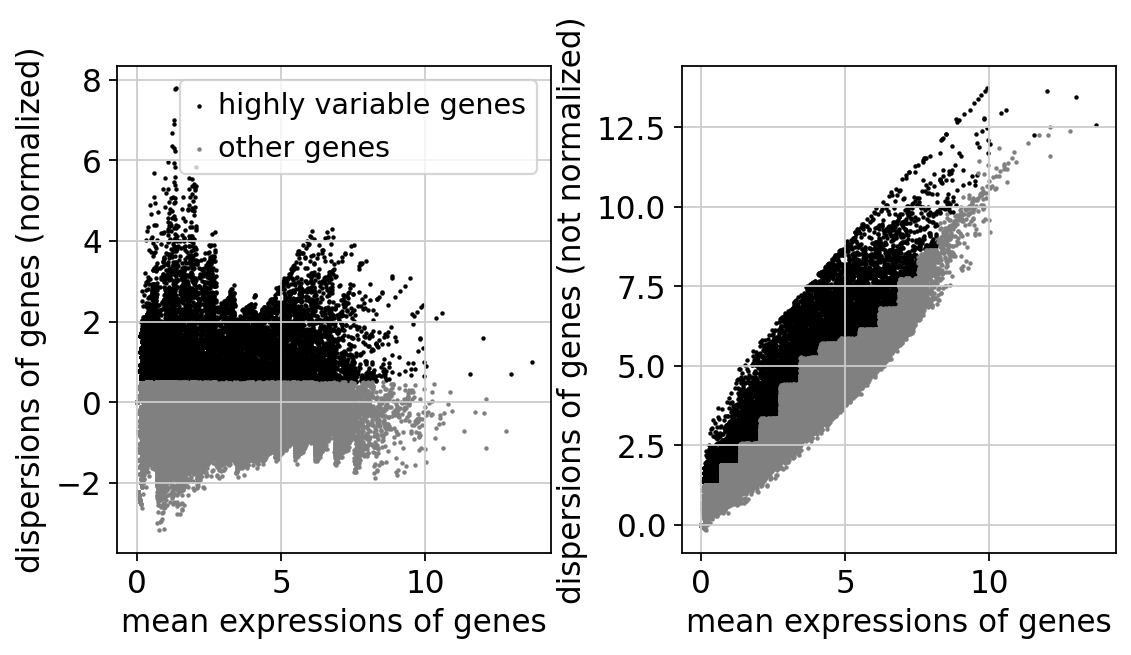

In [20]:
# normalize to 10K counts per cell
#sc.pp.normalize_total(adata, target_sum=1e6)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0, max_mean=15, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
#adata.raw = adata


In [21]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=20)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## PCA

In [22]:
sc.tl.pca(adata, n_comps=10)
sc.pp.neighbors(adata)
sc.tl.tsne(adata)


computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)


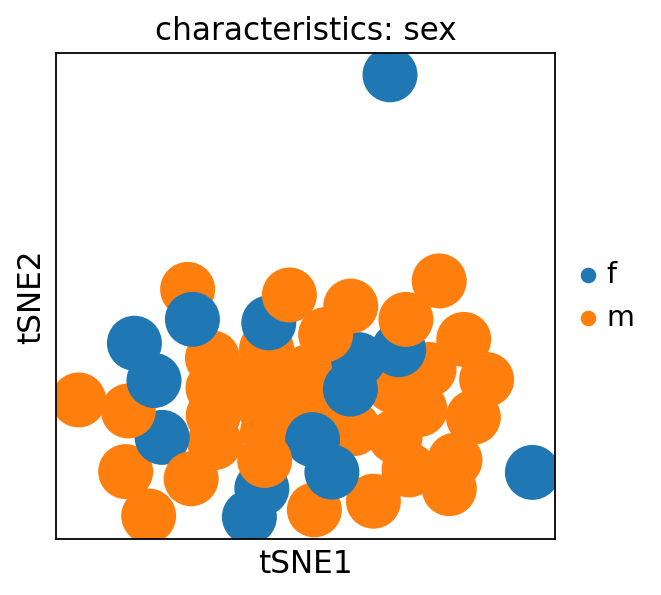

In [23]:
sc.pl.tsne(adata, color="characteristics: sex")

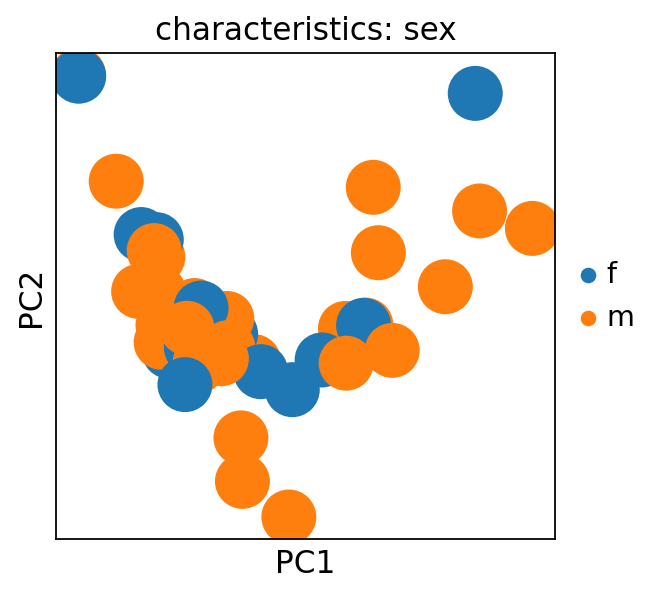

In [24]:
sc.pl.pca(adata, color="characteristics: sex")

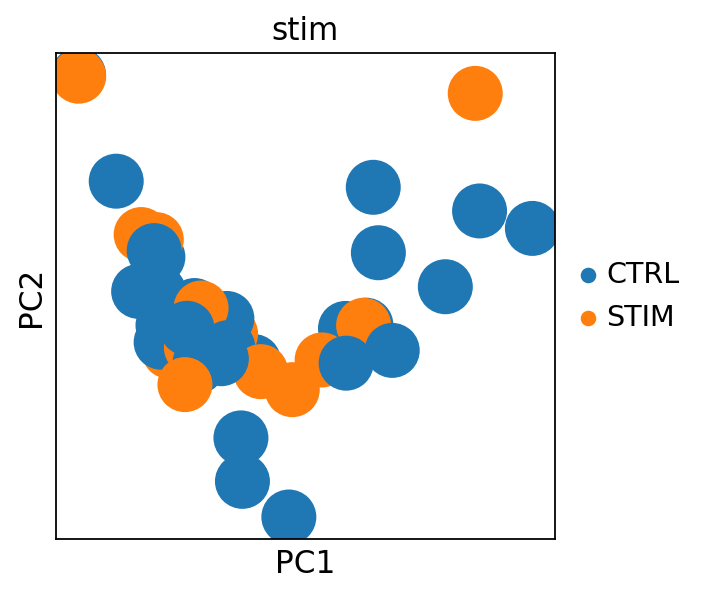

In [25]:
sc.pl.pca(adata, color="stim")

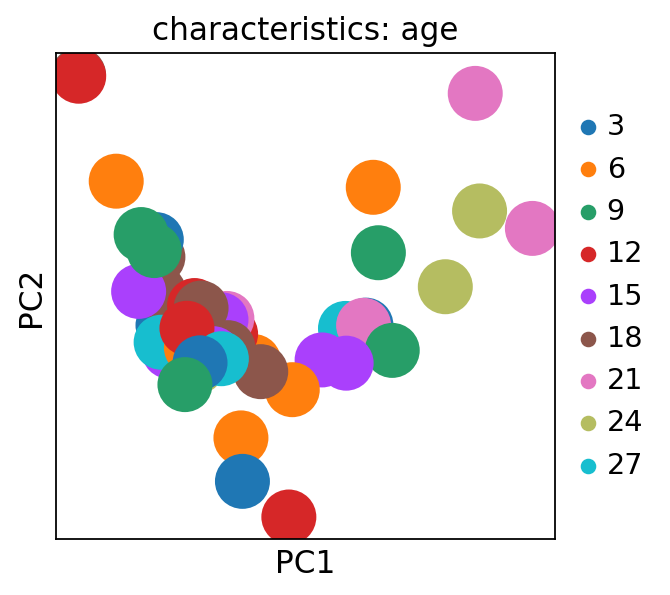

In [27]:
sc.pl.pca(adata, color="characteristics: age")

In [29]:
adata.obs["plate_id"] = [x.split("_")[2] for x in adata.obs["Sample name"] ]

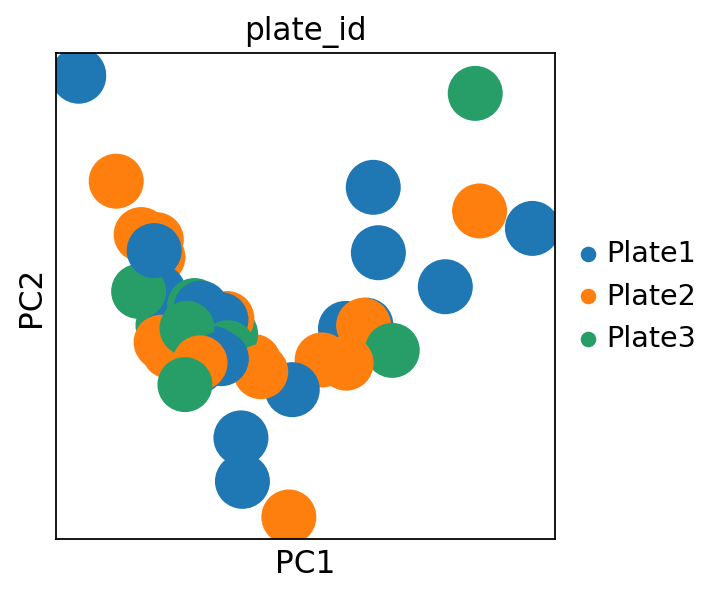

In [30]:
sc.pl.pca(adata, color="plate_id")

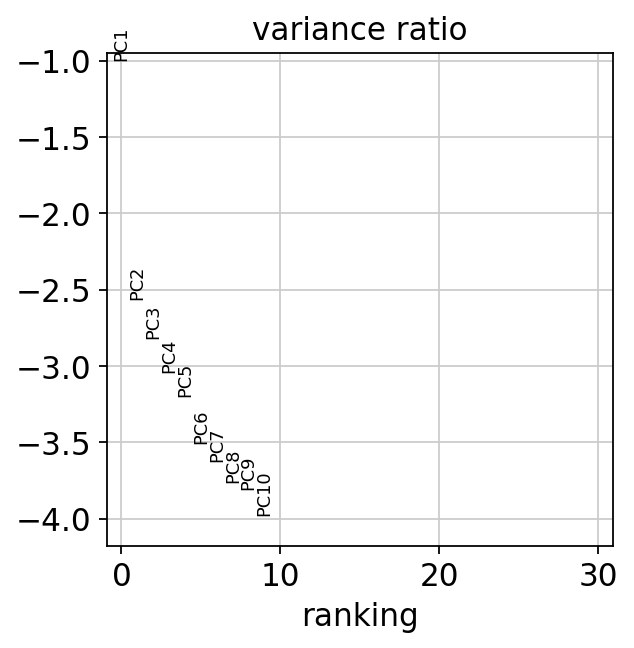

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)



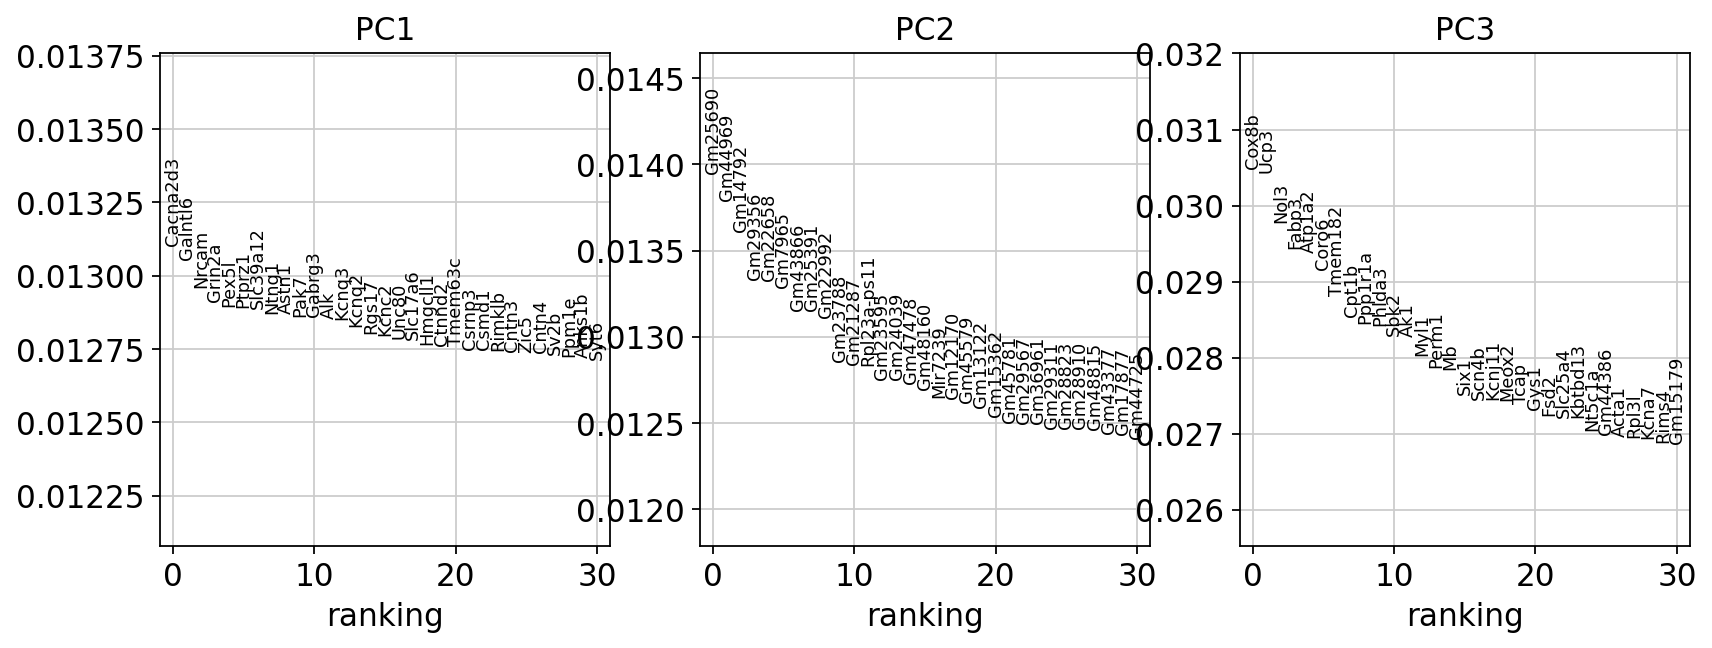

In [23]:
sc.pl.pca_loadings(adata, include_lowest=False)
